In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re 
import pickle

import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.remove('most')

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams

from collections import Counter
import itertools

from textblob import TextBlob
import text2emotion as te

import spacy
from spacy import displacy

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import os
cwd = os.getcwd().replace('\\', '/') + '/'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jguer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jguer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jguer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TextBlob https://textblob.readthedocs.io/en/dev/

#### Data

In [2]:
path_data = cwd + 'Output/'

In [3]:
df = pd.read_csv(path_data + 'Preprocessed_Memos.csv', index_col=0, parse_dates=True)
df = df.sort_index()

df.tail(3)

,preprocessed_memo,full_sentences
2020-08-05,time thinking early week month novel coronavir...,time for thinking in the early weeks and month...
2020-10-13,coming focus roughly two month passed since la...,coming into focus roughly two months have pass...
2021-01-11,something value asked possible silver lining p...,something of value if asked about possible sil...


In [4]:
memo_prep = df['preprocessed_memo'].iloc[0]
memo = df['full_sentences'].iloc[0]

preprocessed_memos = ' '.join([M for M in df['preprocessed_memo']])
full_memos = ' '.join([F for F in df['full_sentences']])

len(preprocessed_memos.split()), len(full_memos.split())

(337708, 629195)

#### Polarity & Emotion

##### TextBlob

Subjectivity ranges : 0 very objetcive to 1 very subjetive

Polarity ranges : -1 very negative to 1 very positive

In [5]:
calculate_TextBlob=False
if calculate_TextBlob : 
    
    for i in df.index : # takes 4s

        memo = df.loc[i, 'preprocessed_memo']

        textblob_memo = TextBlob(memo).sentiment
        df.loc[i, 'TextBlob_Polarity'] = textblob_memo.polarity
        df.loc[i, 'TextBlob_Subjectivity'] = textblob_memo.subjectivity
    
else : 
    df = pd.read_csv(path_data + 'Sentiment_Memos.csv', index_col=0, parse_dates=True)
    
df.head(1)

,preprocessed_memo,full_sentences,Happy,Surprise,Sad,Fear,Anger,TextBlob_Polarity,TextBlob_Subjectivity,TextBlob_Polarity_sents,TextBlob_Objectivity_sents
1990-10-12,route performance seek investment performance ...,the route to performance we all seek investmen...,0.01,0.2,0.21,0.57,0.01,0.057496,0.530668,0.333333,-0.034483


In [6]:
calculate_sentence_polarity=True
if calculate_sentence_polarity : 
    
    for i in df.index : # takes 30s

        memo = df.loc[i, 'preprocessed_memo']
        pol = []
        subj = []
        for sent in memo.split('.') : 
            pol += [TextBlob(sent).sentiment.polarity]
            subj += [TextBlob(sent).sentiment.subjectivity]

        pol = [p for p in pol if abs(p) > 0]
        n_pos = len([p for p in pol if p > 0])
        n_neg = len([p for p in pol if p < 0])
        df.loc[i, 'TextBlob_Polarity_sents'] = (n_pos / (n_pos + n_neg)) * 2 - 1

        #subj = [s for s in subj if abs(s) > 0.1]
        n_subj = len([s for s in subj if s > 0.5])
        n_obj = len([s for s in subj if s < 0.5])
        df.loc[i, 'TextBlob_Objectivity_sents'] = (n_obj / (n_subj + n_obj)) * 2 - 1

else : 
    df = pd.read_csv(path_data + 'Sentiment_Memos.csv', index_col=0, parse_dates=True)

df.tail(2)

,preprocessed_memo,full_sentences,Happy,Surprise,Sad,Fear,Anger,TextBlob_Polarity,TextBlob_Subjectivity,TextBlob_Polarity_sents,TextBlob_Objectivity_sents
2020-10-13,coming focus roughly two month passed since la...,coming into focus roughly two months have pass...,0.08,0.13,0.20,0.54,0.04,0.091502,0.449760,0.460674,0.368421
2021-01-11,something value asked possible silver lining p...,something of value if asked about possible sil...,0.10,0.15,0.17,0.54,0.04,0.107523,0.503103,0.490196,0.190349


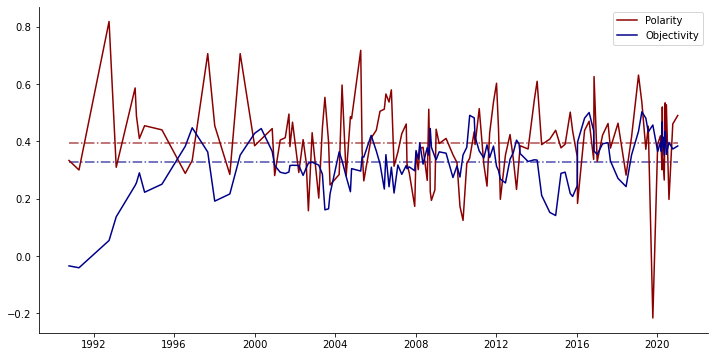

In [7]:
plt.figure(figsize=(12, 6))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


plt.plot(df['TextBlob_Polarity_sents'], #.rolling(3, 0).mean() 
         label='Polarity', c='darkred')
plt.plot(df['TextBlob_Objectivity_sents'].rolling(3, 0).mean(), 
         label='Objectivity', c='darkblue')

xmin=df.index[0]
xmax=df.index[-1]
plt.hlines(y=df['TextBlob_Polarity_sents'].mean(), xmin=xmin, xmax=xmax, 
           colors='darkred', ls='-.', alpha=0.7)
plt.hlines(y=df['TextBlob_Objectivity_sents'].mean(), xmin=xmin, xmax=xmax, 
           colors='darkblue', ls='-.', alpha=0.7)

plt.legend()
plt.show()

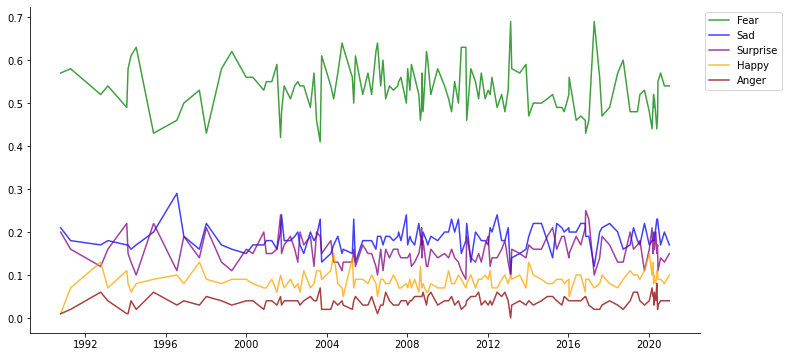

In [8]:
plt.figure(figsize=(12, 6))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

dict_cols = {'Fear' : 'green',
             'Sad' : 'blue',
             'Surprise' : 'purple',
             'Happy' : 'orange',
             'Anger' : 'darkred'}

for col, c in dict_cols.items() : 
    plt.plot(df[col].rolling(1, 0).mean(), c=c, label=col, alpha=0.75)
    
#plt.title('Emotion scores in Howard Marks memos')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

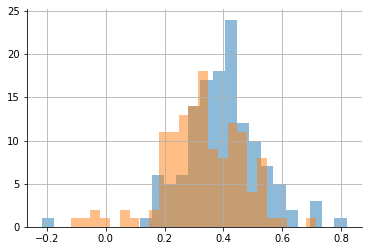

In [9]:
df['TextBlob_Polarity_sents'].hist(bins=25, alpha=0.5, label='Polarity')
df['TextBlob_Objectivity_sents'].hist(bins=25, alpha=0.5, label='Objectivity');

##### text2emotion

In [10]:
calculate_text2emotion=False
if calculate_text2emotion :

    for i in df.index :  # takes 1h ?
        print(i)

        memo = df.loc[i, 'preprocessed_memo']
        emotions_score = te.get_emotion(memo)

        df.loc[i, 'Happy'] = emotions_score['Happy']
        df.loc[i, 'Surprise'] = emotions_score['Surprise']
        df.loc[i, 'Sad'] = emotions_score['Sad']
        df.loc[i, 'Fear'] = emotions_score['Fear']
        df.loc[i, 'Anger'] = emotions_score['Angry']
    
else : 
    df = pd.read_csv(path_data + 'Sentiment_Memos.csv', index_col=0, parse_dates=True)
    
df.head(1)

,preprocessed_memo,full_sentences,Happy,Surprise,Sad,Fear,Anger,TextBlob_Polarity,TextBlob_Subjectivity,TextBlob_Polarity_sents,TextBlob_Objectivity_sents
1990-10-12,route performance seek investment performance ...,the route to performance we all seek investmen...,0.01,0.2,0.21,0.57,0.01,0.057496,0.530668,0.333333,-0.034483


In [11]:
df_res = pd.DataFrame()
df_res.index.name = 'quantile'

for emo in ['TextBlob_Polarity', 'TextBlob_Subjectivity', 'Happy', 'Surprise', 'Sad', 'Fear', 'Anger'] : 
    for q in [0, 0.25, 0.5, 0.75, 1] : 
        df_res.loc[q, emo] = df[emo].quantile(q)

df_res = df_res.rename(columns={'TextBlob_Polarity':'Polarity', 'TextBlob_Subjectivity':'Subjectivity'})
df_res.index = ['min', 0.25, 0.5, 0.75, 'max']
        
df_res

,Polarity,Subjectivity,Happy,Surprise,Sad,Fear,Anger
min,-0.015165,0.397604,0.01,0.09,0.10,0.41,0.00
0.25,0.074892,0.444780,0.07,0.13,0.17,0.49,0.03
0.5,0.092198,0.468035,0.09,0.15,0.18,0.53,0.04
0.75,0.116243,0.486979,0.10,0.17,0.20,0.57,0.05
max,0.220140,0.573273,0.15,0.25,0.29,0.69,0.08


#### Word Cloud

In [12]:
stopwords_wc = set(STOPWORDS)
stopwords_wc.update(stopwords)
stopwords_wc.update(['thus', 'might', 'thats'])
stopwords_wc.remove('most')

In [13]:
# use image as amsk : increase words definition quality
oaktree_mask = np.array(Image.open(cwd + "image/oaktree3.1.jpg"))
transformed_oaktree_mask = np.ndarray((oaktree_mask.shape[0], oaktree_mask.shape[1]), int)

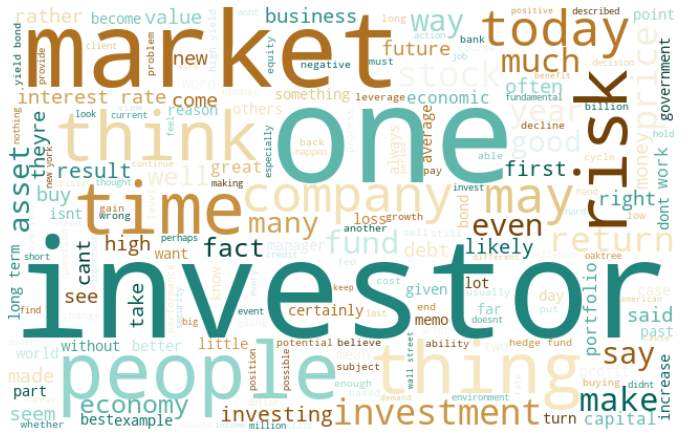

In [14]:
wc_memo = WordCloud(background_color="white", mask=transformed_oaktree_mask, colormap='BrBG',
                   stopwords=stopwords_wc, contour_width=1.5, #max_font_size=50,
                   contour_color='darkgreen').generate(preprocessed_memos)

plt.figure(figsize=[12, 10])
plt.imshow(wc_memo, interpolation='bilinear')
plt.axis("off")
plt.show()

save=False
if save : wc_memo.to_file(cwd + "Output/WordCloud_Oaktree1.png")

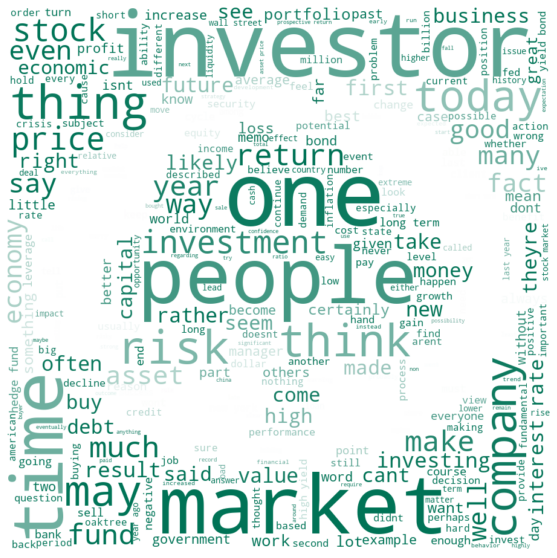

In [15]:
# create coloring from image

mask = np.array(Image.open(cwd + "image/oaktree2.jpg")) # oaktree2 oaktree3.2
wordcloud_memo = WordCloud(stopwords=stopwords_wc, background_color="white", max_words=300, 
                          mode="RGBA", mask=mask).generate(preprocessed_memos)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12, 10])
plt.imshow(wordcloud_memo.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

save=False
if save : wordcloud_memo.to_file(cwd + "Output/WordCloud_Oaktree3.png")

#### N-grams

In [16]:
def N_Gram(text, n=1, save=False) : 

    tokenized = [w for w in nltk.word_tokenize(text) if w not in stopwords and len(w) > 2]

    N_grams = ngrams(tokenized, n)
    N_grams = [ ' '.join(grams) for grams in N_grams]

    Ngrams_tags = nltk.pos_tag(N_grams)
    
    Ngrams_freq = dict(nltk.FreqDist(N_grams))
    Ngrams_freq = dict(sorted(Ngrams_freq.items(), key=lambda x: x[1], reverse=True))
    #Ngrams_freq = dict(itertools.islice(Ngrams_freq.items(), 100))  

    if save : 
        with open(path_data + "%i_Grams.txt" %n, "wb") as fp : pickle.dump(N_grams, fp)
        with open(path_data + "%i_Grams_tag.txt" %n, "wb") as fp : pickle.dump(Ngrams_tags, fp)
        np.save(path_data + '%i_Grams_freq.npy' %n, Ngrams_freq)

    return N_grams, Ngrams_tags, Ngrams_freq

In [17]:
# Most frequently occuring words

cv=CountVectorizer(max_df=0.8, stop_words=stopwords, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(preprocessed_memos.split('.'))

dict(sorted(cv.vocabulary_.items(), key=lambda x: x[1], reverse=True))

{'zone': 9999,
 'zero return': 9998,
 'zero': 9997,
 'youve heard': 9996,
 'youve got get': 9995,
 'youve got': 9994,
 'youve': 9993,
 'youthful always supremely': 9992,
 'youthful always': 9991,
 'youthful': 9990,
 'youre willing': 9989,
 'youre right': 9988,
 'youre likely': 9987,
 'youre': 9986,
 'young': 9985,
 'youll see': 9984,
 'youll probably': 9983,
 'youll find': 9982,
 'youll': 9981,
 'youd': 9980,
 'yorkers': 9979,
 'yorker': 9978,
 'york time wrote': 9977,
 'york time september': 9976,
 'york time reported': 9975,
 'york time may': 9974,
 'york time june': 9973,
 'york time july': 9972,
 'york time february': 9971,
 'york time august': 9970,
 'york time april': 9969,
 'york time': 9968,
 'york city': 9967,
 'york': 9966,
 'yogi berra': 9965,
 'yogi': 9964,
 'yields': 9963,
 'yielding': 9962,
 'yielded': 9961,
 'yield year treasury': 9960,
 'yield year': 9959,
 'yield spread': 9958,
 'yield ratio': 9957,
 'yield maturity': 9956,
 'yield low': 9955,
 'yield high': 9954,
 'yi

In [18]:
# 3-grams
calculate_gram=False 
if calculate_gram : three_grams, threegram_tags, threegram_freq = N_Gram(full_memos, n=3, save=True)
else : 
    with open(path_data + "3_Grams.txt", "rb") as fp : three_gram = pickle.load(fp)
    with open(path_data + "3_Grams_tag.txt", "rb") as fp : threegram_tags = pickle.load(fp)
    threegram_freq = np.load(path_data + '3_Grams_freq.npy', allow_pickle ='TRUE').item()

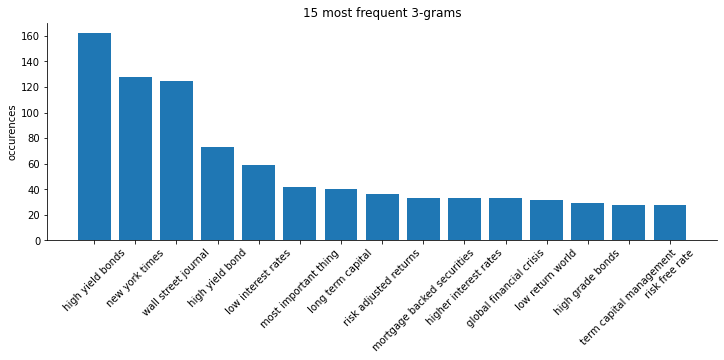

In [19]:
plt.figure(figsize=(12, 4))

topn = 15
D3 = dict(list(threegram_freq.items())[:topn])
plt.bar(range(len(D3)), list(D3.values()), align='center')

plt.title('%i most frequent 3-grams' %topn)
plt.xticks(range(len(D3)), list(D3.keys()), rotation=45)
plt.ylabel('occurences')
plt.show()

#### Name Entity Recognition

In [20]:


nlp = spacy.load('en_core_web_sm')
doc = nlp(memo)

doc.ents

(first,
 one,
 last year,
 one,
 last year,
 two,
 first,
 one,
 one,
 first,
 one,
 one third,
 three year,
 month,
 early year decade,
 first,
 fifty,
 fifty,
 fifty,
 year,
 many years,
 fifty half,
 two,
 last fifty years,
 one,
 today,
 past decade,
 past year,
 two,
 fifty,
 one,
 one,
 two,
 first,
 two,
 appreciate year,
 today,
 today,
 first,
 first,
 today,
 second,
 first,
 annual,
 third,
 thousand,
 one,
 american,
 farmer decade,
 early year century,
 annual,
 today,
 ten thousand,
 trillion dollars,
 warren,
 year,
 annual,
 seconds,
 billion dollar,
 annually,
 last forty year,
 today,
 annual,
 today,
 warren,
 two,
 today,
 almost year ago,
 today,
 stanford,
 today,
 fifty,
 today,
 today,
 coming decade,
 today,
 today,
 today,
 today,
 two,
 year ago,
 next several year,
 next year,
 years,
 every night,
 one,
 first,
 second,
 today,
 one,
 five years,
 today,
 four,
 today,
 first,
 three,
 four,
 today,
 one,
 first,
 two,
 four,
 one,
 today,
 first,
 today,
 

In [21]:
#displacy.serve(doc, style="ent")
displacy.render(doc, style="ent")
# displacy.render(doc, style='dep') # for the arrows and links

#### K-Mean

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/


KMean text clustering https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d


In [22]:
corpus = [S.strip() for F in df['preprocessed_memo'] for S in F.split('.')]

In [23]:
# classify sentences with Kmean # takes 8 min

classify_articles=False
if classify_articles : 
    
    vectorizer = TfidfVectorizer(stop_words={'english'})
    X = vectorizer.fit_transform(corpus)

    K = 10
    model = KMeans(n_clusters=K, init='k-means++', max_iter=100, n_init=5)
    model.fit(X)

    labels = model.labels_
    df_kmean = pd.DataFrame(list(zip(corpus,labels)), columns=['content', 'cluster'])

    df_kmean = df_kmean.sort_values(by=['cluster'])

    save=False
    if save : 
        df_kmean.to_csv(path_data + 'Articles_KGroups.csv')
        np.savetxt(path_data + 'Class_labels.txt', labels, fmt='%d')
    
else : 
    df_kmean = pd.read_csv(path_data + 'Articles_KGroups.csv', index_col=0)
    labels = np.loadtxt(path_data + 'Class_labels.txt', dtype=int)

Cluster 0
Key words :  ['risk', 'investor', 'return', 'investment', 'market']


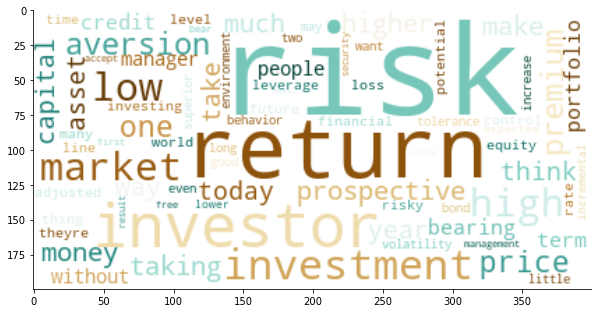

Cluster 1
Key words :  ['fund', 'hedge fund', 'return', 'year', 'capital']


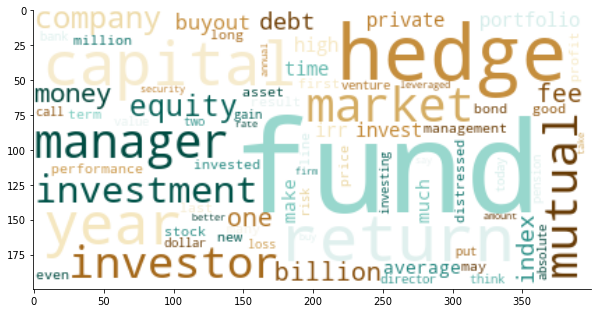

Cluster 2
Key words :  ['stock', 'price', 'market', 'bond', 'investor']


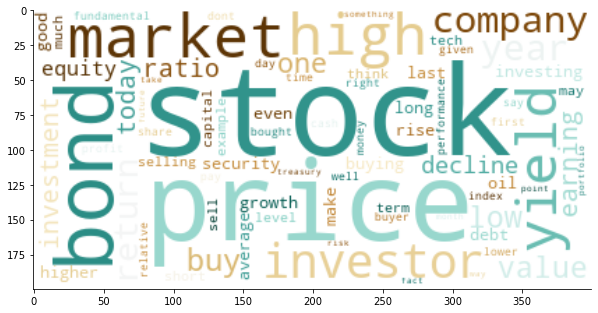

Cluster 3
Key words :  ['know', 'dont know', 'market', 'investor', 'thing']


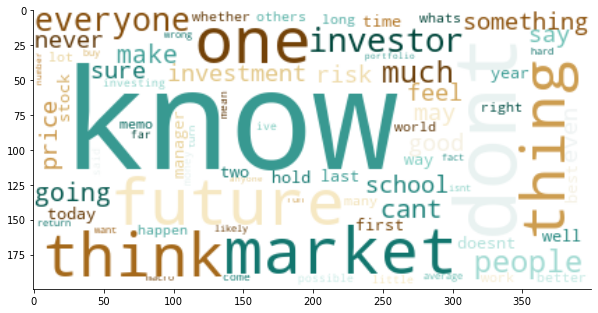

Cluster 4
Key words :  ['thing', 'one', 'people', 'market', 'investor']


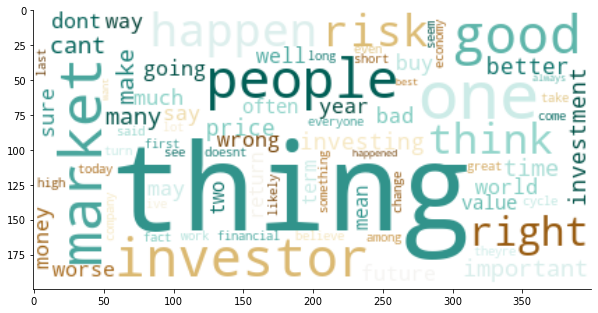

Cluster 5
Key words :  ['asset', 'price', 'asset price', 'investor', 'market']


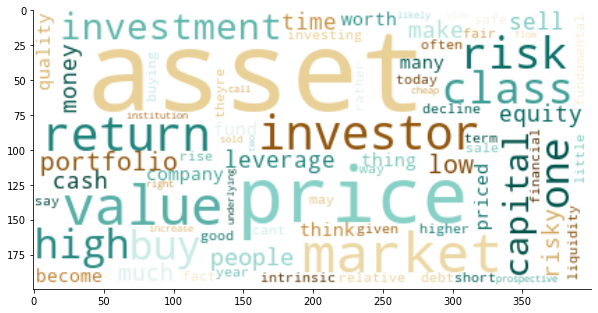

Cluster 6
Key words :  ['people', 'market', 'make', 'one', 'investment']


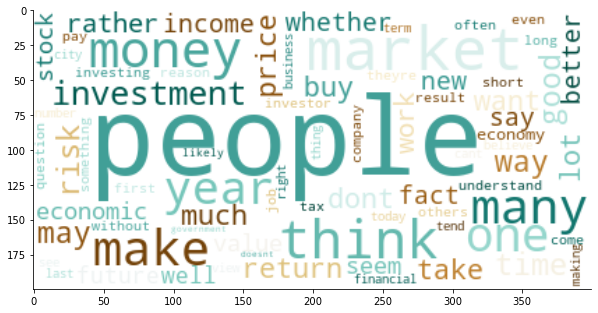

Cluster 7
Key words :  ['interest rate', 'rate', 'low', 'fed', 'return']


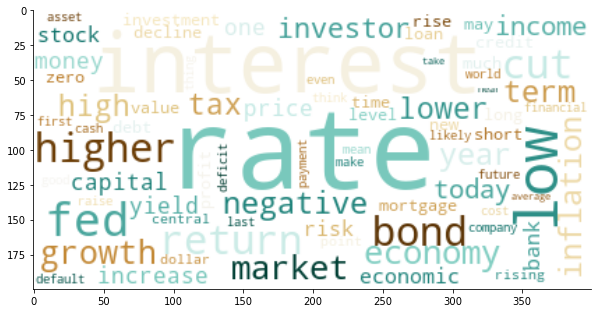

Cluster 8
Key words :  ['one', 'investor', 'market', 'thus', 'think']


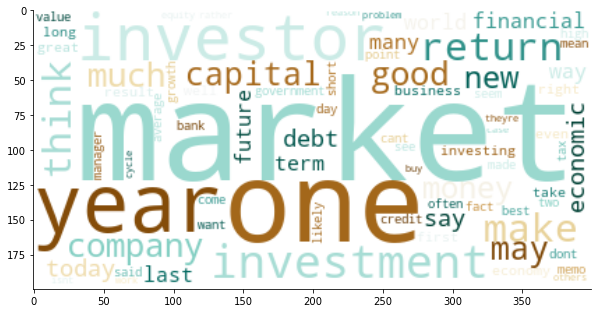

Cluster 9
Key words :  ['time', 'market', 'new york', 'york time', 'investor']


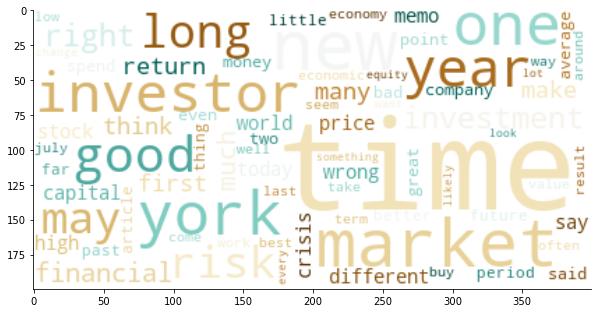

In [24]:
# WordCloud per class

result = pd.DataFrame({'cluster':labels, 'content':corpus})
K = 10
for k in range(0, K):
    
    words_K = result[result.cluster==k]
    str_K = ' '.join([sent for sent in words_K['content']])

    dict_WC_freq = WordCloud().process_text(str_K)
    top_wc_kw = sorted(dict_WC_freq.items(),key=lambda x:(-x[1],x[0]),reverse=False)[:5]
    top_wc_kw = [kw[0] for kw in top_wc_kw]
    
    print('Cluster %i' %k)
    print('Key words : ', top_wc_kw)

    wordcloud_K = WordCloud(max_words=75, stopwords=stopwords_wc, colormap='BrBG', 
                          background_color='white', collocations=False).generate(str_K)
    
    plt.figure(figsize=[10, 8])
    plt.imshow(wordcloud_K, interpolation='bilinear')
    plt.show()
    
    save=False
    if save : wordcloud_K.to_file(cwd + "Output/WordCloud_Class%i.png" %k)

#### Words occurences

In [25]:
to_count = ['risk', 'opportunity', 'optimism', 'pessimism', 'fear', 'greed', 'bull', 'bear', 
            'crisis', 'expansion', 'bubble', 'euphoria']
negwords = ['risk','pessimism','fear','bear',]
poswords = ['opportunity','optimism','greed','bull',]

df_count = df[['preprocessed_memo']].copy()

for i in df_count.index : 
    for word in to_count : 
        df_count.loc[i, word] = df_count.loc[i, 'preprocessed_memo'].count(word)

df_count.sum()

preprocessed_memo    route performance seek investment performance ...
risk                                                              3154
opportunity                                                        293
optimism                                                           132
pessimism                                                           39
fear                                                               227
greed                                                               92
bull                                                               274
bear                                                               309
crisis                                                             433
expansion                                                           61
bubble                                                             194
euphoria                                                            37
dtype: object

In [26]:
df_compare = pd.DataFrame()

df_compare['Negative'] = df_count.sum().loc[negwords].index
df_compare['count neg'] = df_count.sum().loc[negwords].values
df_compare['Positive'] = df_count.sum().loc[poswords].index
df_compare['count pos'] = df_count.sum().loc[poswords].values

df_compare

,Negative,count neg,Positive,count pos
0,risk,3154,opportunity,293
1,pessimism,39,optimism,132
2,fear,227,greed,92
3,bear,309,bull,274


In [27]:
def Graph_Occ(Neg, Pos, roll=4):

    plt.figure(figsize=(12, 4))
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False

    plt.plot(df_count[Neg].rolling(roll).mean(), label=Neg.capitalize(), c='darkred')
    plt.plot(df_count[Pos].rolling(roll).mean(), label=Pos.capitalize(), c='darkblue')

    plt.title('Occurences of %s vs %s' % (Pos, Neg), fontsize=13)
    plt.legend()
    plt.show()

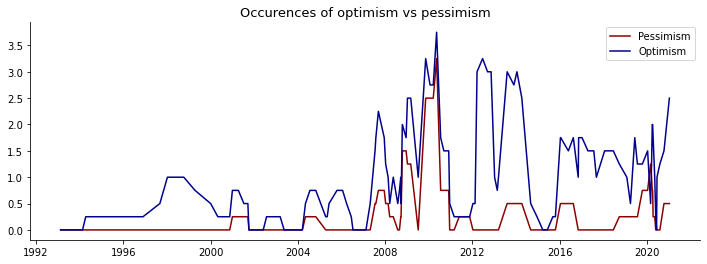

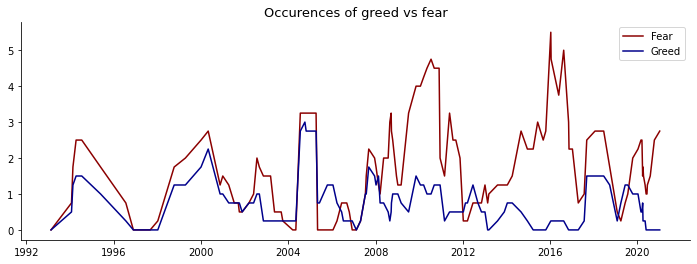

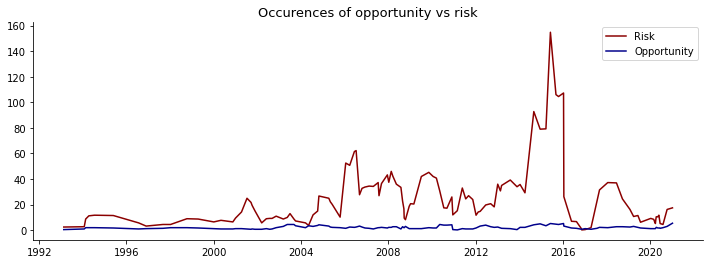

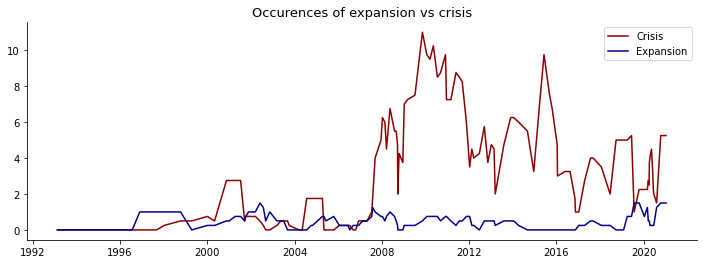

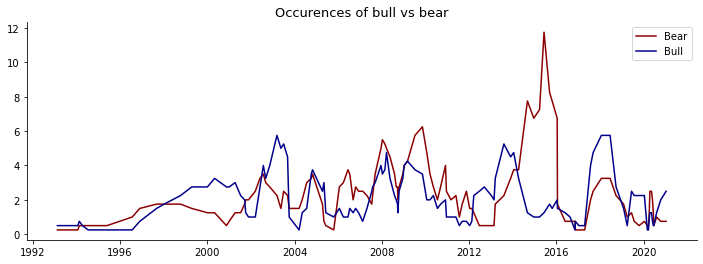

In [28]:
Graph_Occ('pessimism', 'optimism')

Graph_Occ('fear', 'greed')

Graph_Occ('risk', 'opportunity')

Graph_Occ('crisis', 'expansion')

Graph_Occ('bear', 'bull')

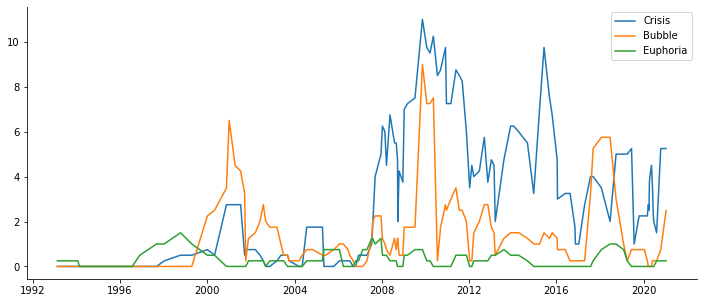

In [29]:
plt.figure(figsize=(12, 5))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

for word in ['crisis', 'bubble', 'euphoria'] : 
    plt.plot(df_count[word].rolling(4).mean(), label=word.capitalize())

plt.legend()
plt.show()